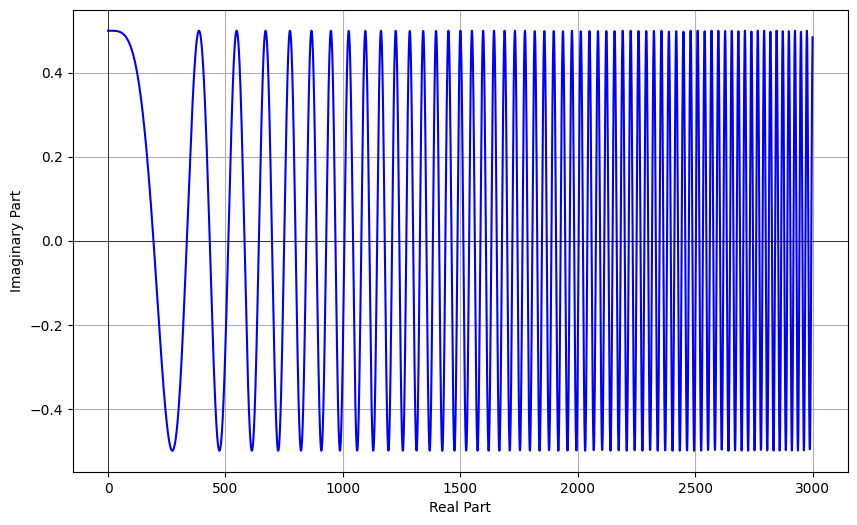

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('sweep.csv')

# Extract real and imaginary parts
real = df['Real']
imaginary = df['Imaginary']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(real, linestyle='-', color='b')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()


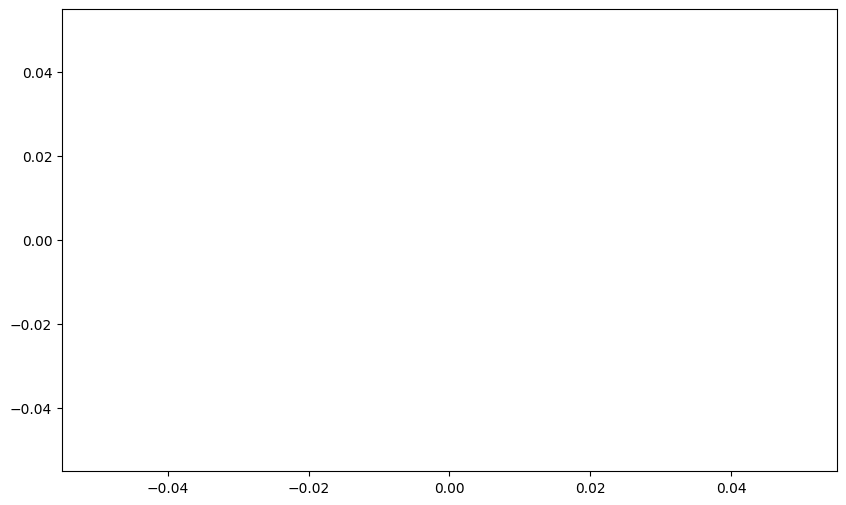

In [32]:
fs = 1000000  # 1 MHz
T = 1/fs
X = np.fft.fft(real)
N = len(X)
f = np.fft.fftfreq(N, T)



E = 500
plt.figure(figsize=(10, 6))
plt.plot(f[-E:E], np.abs(X)[-E:E])
plt.show()